In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

2023-08-22 19:53:54 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-08-22 19:53:54 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl.gz'))
print(len(real_game_texts), len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-08-22 19:53:56 - src.ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-08-22 19:53:56 - src.ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


98 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.969698,0.980189,0.972097,0.982683,0.983234,0.984843,0.941296,0.930606,0.994540,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.986488,0.985033,0.968718,0.980055,0.979109,0.985450,0.923794,0.930399,0.947819,0.953640
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.948358,0.973556,0.000000,0.000000,0.000000,0.000000,0.864027,0.869713,0.939114,0.951486
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.987400,0.980873,0.000000,0.000000,0.000000,0.000000,0.941296,0.930606,0.994540,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.985927,0.981736,0.000000,0.000000,0.000000,0.000000,0.978163,0.977679,0.974040,0.979537


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID, LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
# model_date_id = 'full_features_no_in_data_all_2023_08_09'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



354


In [6]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [7]:
real_game_scores = full_tensor_scores[:, 0]

print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
print(f'20th percentile negative energy: {torch.quantile(negatives_scores.ravel(), 0.2)}')

Real game scores: -108.5644 ± 1.1007, min = -112.7425, max = -106.6479
20th percentile negative energy: -102.0732192993164


In [8]:
steps = torch.linspace(0, 1, 11)
deciles = torch.quantile(negatives_scores.ravel(), steps)
print(steps)
print(f'Energy deciles: {deciles}')

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])
Energy deciles: tensor([-111.1921, -104.5640, -102.0732, -100.3218,  -98.5752,  -96.5611,
         -94.4282,  -91.5008,  -86.6422,  -76.3096,   -3.2304])


Weights mean: 0.1063, std: 3.0832, bias: 0.0100


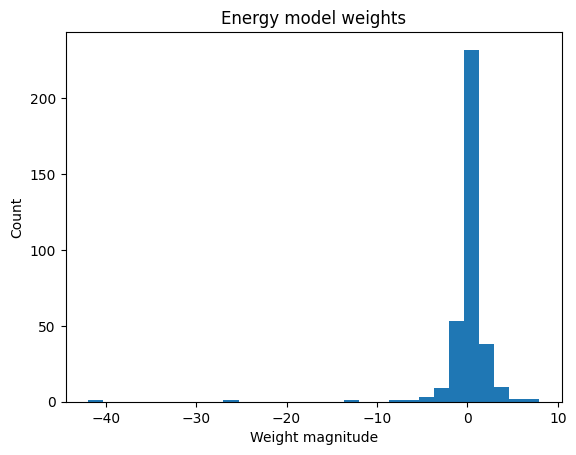

In [9]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [10]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (36, 10.17%) of the weights have magnitude < 0.0671
Approximately 25.0% (89, 25.14%) of the weights have magnitude < 0.1930
Approximately 50.0% (180, 50.85%) of the weights have magnitude < 0.5789
Approximately 75.0% (266, 75.14%) of the weights have magnitude < 1.1409
Approximately 90.0% (319, 90.11%) of the weights have magnitude < 2.3909
Approximately 95.0% (337, 95.20%) of the weights have magnitude < 3.1292
Approximately 99.0% (351, 99.15%) of the weights have magnitude < 7.9362


In [11]:
GRAMMAR_CONTEXT_FEATURES = [
    'variables_defined_all',
    'variables_defined_incorrect_count',
    'variables_used_all',
    'variables_used_incorrect_count',
    'preferences_used_all',
    'preferences_used_incorrect_count',

    'repeated_variables_found',
    'repeated_variable_type_in_either',

    'section_without_pref_or_total_count_terminal',
    'section_without_pref_or_total_count_scoring',
    'section_doesnt_exist_setup',
    'section_doesnt_exist_terminal',
]

NGRAM_AND_DATA_BASED_FEATURES = [
    'predicate_found_in_data_setup_prop',
    'predicate_found_in_data_constraints_prop',
    'ast_ngram_full_n_5_score',
    'ast_ngram_setup_n_5_score',
    'ast_ngram_constraints_n_5_score',
    'ast_ngram_terminal_n_5_score',
    'ast_ngram_scoring_n_5_score'
]

COUNTING_FEATURES = [
    # How many preferences are defined
    'num_preferences_defined_1',
    'num_preferences_defined_2',
    'num_preferences_defined_3',
    'num_preferences_defined_4',
    'num_preferences_defined_5',
    'num_preferences_defined_6',
    # How many modals are under a then
    'length_of_then_modals_1',
    'length_of_then_modals_2',
    'length_of_then_modals_3',
    'length_of_then_modals_4',
    'length_of_then_modals_5',
    'length_of_then_modals_6',
    'length_of_then_modals_7',
    # Various features related to variable quantifications
    'max_quantification_count_setup_0',
    'max_quantification_count_setup_1',
    'max_quantification_count_setup_2',
    'max_quantification_count_setup_3',
    'max_quantification_count_setup_4',
    'max_quantification_count_setup_5',
    'max_quantification_count_constraints_0',
    'max_quantification_count_constraints_1',
    'max_quantification_count_constraints_2',
    'max_quantification_count_constraints_3',
    'max_quantification_count_constraints_4',
    'max_quantification_count_constraints_5',
    'max_number_variables_types_quantified_types_1',
    'max_number_variables_types_quantified_types_2',
    'max_number_variables_types_quantified_types_3',
    'max_number_variables_types_quantified_types_4',
    'max_number_variables_types_quantified_types_5',
    'max_number_variables_types_quantified_types_6',
    'max_number_variables_types_quantified_types_7',
    'max_number_variables_types_quantified_types_8',
    'max_number_variables_types_quantified_variables_1',
    'max_number_variables_types_quantified_variables_2',
    'max_number_variables_types_quantified_variables_3',
    'max_number_variables_types_quantified_variables_4',
    'max_number_variables_types_quantified_variables_5',
    'max_number_variables_types_quantified_variables_6',
    'max_number_variables_types_quantified_variables_7',
    'max_number_variables_types_quantified_variables_8',
    # Man and max depth and node count
    'max_depth_setup_0',
    'max_depth_setup_1',
    'max_depth_setup_2',
    'max_depth_setup_3',
    'max_depth_setup_4',
    'max_depth_constraints_0',
    'max_depth_constraints_1',
    'max_depth_constraints_2',
    'max_depth_constraints_3',
    'max_depth_constraints_4',
    'max_depth_terminal_0',
    'max_depth_terminal_1',
    'max_depth_terminal_2',
    'max_depth_terminal_3',
    'max_depth_terminal_4',
    'max_depth_scoring_0',
    'max_depth_scoring_1',
    'max_depth_scoring_2',
    'max_depth_scoring_3',
    'max_depth_scoring_4',
    'mean_depth_setup_0',
    'mean_depth_setup_1',
    'mean_depth_setup_2',
    'mean_depth_setup_3',
    'mean_depth_setup_4',
    'mean_depth_constraints_0',
    'mean_depth_constraints_1',
    'mean_depth_constraints_2',
    'mean_depth_constraints_3',
    'mean_depth_constraints_4',
    'mean_depth_terminal_0',
    'mean_depth_terminal_1',
    'mean_depth_terminal_2',
    'mean_depth_terminal_3',
    'mean_depth_terminal_4',
    'mean_depth_scoring_0',
    'mean_depth_scoring_1',
    'mean_depth_scoring_2',
    'mean_depth_scoring_3',
    'mean_depth_scoring_4',
    'node_count_setup_0',
    'node_count_setup_1',
    'node_count_setup_2',
    'node_count_setup_3',
    'node_count_setup_4',
    'node_count_constraints_0',
    'node_count_constraints_1',
    'node_count_constraints_2',
    'node_count_constraints_3',
    'node_count_constraints_4',
    'node_count_terminal_0',
    'node_count_terminal_1',
    'node_count_terminal_2',
    'node_count_terminal_3',
    'node_count_terminal_4',
    'node_count_scoring_0',
    'node_count_scoring_1',
    'node_count_scoring_2',
    'node_count_scoring_3',
    'node_count_scoring_4',
]

FORALL_FEATURES = [
    'pref_forall_count_once_per_external_objects_used_correct',
    'pref_forall_count_once_per_external_objects_used_incorrect',
    'pref_forall_count_once_per_external_objects_used_incorrect_count',
    'pref_forall_external_forall_used_correct',
    'pref_forall_external_forall_used_incorrect',
    'pref_forall_external_forall_used_incorrect_count',
    'pref_forall_used_correct',
    'pref_forall_used_incorrect',
    'pref_forall_used_incorrect_count',
    'pref_forall_pref_forall_correct_arity_correct',
    'pref_forall_pref_forall_correct_arity_incorrect',
    'pref_forall_pref_forall_correct_arity_incorrect_count',
    'pref_forall_pref_forall_correct_types_correct',
    'pref_forall_pref_forall_correct_types_incorrect',
    'pref_forall_pref_forall_correct_types_incorrect_count',
]

PREDICATE_UNDER_MODAL_FEATURES = [
    'predicate_under_modal_once_measure_in_motion',
    'predicate_under_modal_once_measure_on',
    'predicate_under_modal_once_measure_between',
    'predicate_under_modal_once_measure_adjacent',
    'predicate_under_modal_once_measure_agent_holds',
    'predicate_under_modal_once_measure_adjacent_side_3',
    'predicate_under_modal_once_measure_object_orientation',
    'predicate_under_modal_once_measure_touch',
    'predicate_under_modal_once_measure_distance',
    'predicate_under_modal_once_measure_in',
    'predicate_under_modal_at_end_in_motion',
    'predicate_under_modal_at_end_on',
    'predicate_under_modal_at_end_between',
    'predicate_under_modal_at_end_adjacent',
    'predicate_under_modal_at_end_agent_holds',
    'predicate_under_modal_at_end_adjacent_side_3',
    'predicate_under_modal_at_end_object_orientation',
    'predicate_under_modal_at_end_touch',
    'predicate_under_modal_at_end_distance',
    'predicate_under_modal_at_end_in',
    'predicate_under_modal_once_in_motion',
    'predicate_under_modal_once_on',
    'predicate_under_modal_once_between',
    'predicate_under_modal_once_adjacent',
    'predicate_under_modal_once_agent_holds',
    'predicate_under_modal_once_adjacent_side_3',
    'predicate_under_modal_once_object_orientation',
    'predicate_under_modal_once_touch',
    'predicate_under_modal_once_distance',
    'predicate_under_modal_once_in',
    'predicate_under_modal_hold_in_motion',
    'predicate_under_modal_hold_on',
    'predicate_under_modal_hold_between',
    'predicate_under_modal_hold_adjacent',
    'predicate_under_modal_hold_agent_holds',
    'predicate_under_modal_hold_adjacent_side_3',
    'predicate_under_modal_hold_object_orientation',
    'predicate_under_modal_hold_touch',
    'predicate_under_modal_hold_distance',
    'predicate_under_modal_hold_in',
    'predicate_under_modal_while_hold_in_motion',
    'predicate_under_modal_while_hold_on',
    'predicate_under_modal_while_hold_between',
    'predicate_under_modal_while_hold_adjacent',
    'predicate_under_modal_while_hold_agent_holds',
    'predicate_under_modal_while_hold_adjacent_side_3',
    'predicate_under_modal_while_hold_object_orientation',
    'predicate_under_modal_while_hold_touch',
    'predicate_under_modal_while_hold_distance',
    'predicate_under_modal_while_hold_in',
]

PREDICATE_ROLE_FILLER_FEATURES = [
    'adjacent_arg_types_balls_furniture_setup',
    'adjacent_arg_types_blocks_furniture_setup',
    'adjacent_arg_types_blocks_room_features_setup',
    'adjacent_arg_types_furniture_large_objects_setup',
    'adjacent_arg_types_furniture_ramps_setup',
    'adjacent_arg_types_furniture_receptacles_setup',
    'adjacent_arg_types_other_setup',
    'adjacent_arg_types_receptacles_room_features_setup',
    'adjacent_arg_types_agent_balls_constraints',
    'adjacent_arg_types_agent_blocks_constraints',
    'adjacent_arg_types_agent_furniture_constraints',
    'adjacent_arg_types_agent_large_objects_constraints',
    'adjacent_arg_types_agent_ramps_constraints',
    'adjacent_arg_types_agent_receptacles_constraints',
    'adjacent_arg_types_agent_room_features_constraints',
    'adjacent_arg_types_other_constraints',
    'adjacent_arg_types_receptacles_room_features_constraints',
    'adjacent_arg_types_room_features_room_features_constraints',
    'adjacent_side_3_arg_types_furniture_sides_large_objects_setup',
    'adjacent_side_3_arg_types_other_setup',
    'adjacent_side_3_arg_types_receptacles_sides_blocks_setup',
    'adjacent_side_3_arg_types_other_constraints',
    'agent_holds_arg_types_other_setup',
    'agent_holds_arg_types_agent_constraints',
    'agent_holds_arg_types_any_object_constraints',
    'agent_holds_arg_types_balls_constraints',
    'agent_holds_arg_types_blocks_constraints',
    'agent_holds_arg_types_furniture_constraints',
    'agent_holds_arg_types_large_objects_constraints',
    'agent_holds_arg_types_other_constraints',
    'agent_holds_arg_types_receptacles_constraints',
    'agent_holds_arg_types_room_features_constraints',
    'agent_holds_arg_types_small_objects_constraints',
    'between_arg_types_other_setup',
    'between_arg_types_other_constraints',
    'distance_arg_types_balls_furniture_setup',
    'distance_arg_types_balls_receptacles_setup',
    'distance_arg_types_balls_room_features_setup',
    'distance_arg_types_blocks_blocks_setup',
    'distance_arg_types_blocks_furniture_setup',
    'distance_arg_types_blocks_receptacles_setup',
    'distance_arg_types_blocks_room_features_setup',
    'distance_arg_types_furniture_receptacles_setup',
    'distance_arg_types_large_objects_room_features_setup',
    'distance_arg_types_other_setup',
    'distance_arg_types_ramps_receptacles_setup',
    'distance_arg_types_ramps_room_features_setup',
    'distance_arg_types_receptacles_room_features_setup',
    'distance_arg_types_agent_balls_constraints',
    'distance_arg_types_agent_furniture_constraints',
    'distance_arg_types_agent_receptacles_constraints',
    'distance_arg_types_agent_room_features_constraints',
    'distance_arg_types_any_object_room_features_constraints',
    'distance_arg_types_balls_blocks_constraints',
    'distance_arg_types_blocks_furniture_constraints',
    'distance_arg_types_blocks_receptacles_constraints',
    'distance_arg_types_furniture_ramps_constraints',
    'distance_arg_types_large_objects_room_features_constraints',
    'distance_arg_types_other_constraints',
    'in_arg_types_building_blocks_setup',
    'in_arg_types_other_setup',
    'in_arg_types_any_object_any_object_constraints',
    'in_arg_types_balls_balls_constraints',
    'in_arg_types_building_any_object_constraints',
    'in_arg_types_building_blocks_constraints',
    'in_arg_types_building_receptacles_constraints',
    'in_arg_types_furniture_small_objects_constraints',
    'in_arg_types_other_constraints',
    'in_arg_types_receptacles_any_object_constraints',
    'in_arg_types_receptacles_balls_constraints',
    'in_arg_types_receptacles_blocks_constraints',
    'in_arg_types_receptacles_building_constraints',
    'in_arg_types_receptacles_large_objects_constraints',
    'in_arg_types_receptacles_receptacles_constraints',
    'in_arg_types_receptacles_small_objects_constraints',
    'in_motion_arg_types_other_setup',
    'in_motion_arg_types_agent_constraints',
    'in_motion_arg_types_any_object_constraints',
    'in_motion_arg_types_balls_constraints',
    'in_motion_arg_types_blocks_constraints',
    'in_motion_arg_types_furniture_constraints',
    'in_motion_arg_types_large_objects_constraints',
    'in_motion_arg_types_other_constraints',
    'in_motion_arg_types_receptacles_constraints',
    'in_motion_arg_types_room_features_constraints',
    'in_motion_arg_types_small_objects_constraints',
    'object_orientation_arg_types_large_objects_orientations_setup',
    'object_orientation_arg_types_other_setup',
    'object_orientation_arg_types_receptacles_orientations_setup',
    'object_orientation_arg_types_large_objects_orientations_constraints',
    'object_orientation_arg_types_other_constraints',
    'object_orientation_arg_types_receptacles_orientations_constraints',
    'on_arg_types_blocks_blocks_setup',
    'on_arg_types_furniture_any_object_setup',
    'on_arg_types_furniture_balls_setup',
    'on_arg_types_furniture_blocks_setup',
    'on_arg_types_furniture_large_objects_setup',
    'on_arg_types_furniture_receptacles_setup',
    'on_arg_types_large_objects_large_objects_setup',
    'on_arg_types_other_setup',
    'on_arg_types_room_features_balls_setup',
    'on_arg_types_room_features_blocks_setup',
    'on_arg_types_any_object_any_object_constraints',
    'on_arg_types_balls_balls_constraints',
    'on_arg_types_blocks_balls_constraints',
    'on_arg_types_blocks_blocks_constraints',
    'on_arg_types_furniture_any_object_constraints',
    'on_arg_types_furniture_balls_constraints',
    'on_arg_types_furniture_large_objects_constraints',
    'on_arg_types_furniture_receptacles_constraints',
    'on_arg_types_furniture_small_objects_constraints',
    'on_arg_types_large_objects_balls_constraints',
    'on_arg_types_large_objects_large_objects_constraints',
    'on_arg_types_large_objects_receptacles_constraints',
    'on_arg_types_other_constraints',
    'on_arg_types_ramps_balls_constraints',
    'on_arg_types_receptacles_agent_constraints',
    'on_arg_types_receptacles_balls_constraints',
    'on_arg_types_receptacles_receptacles_constraints',
    'on_arg_types_room_features_agent_constraints',
    'on_arg_types_room_features_balls_constraints',
    'on_arg_types_room_features_blocks_constraints',
    'on_arg_types_room_features_large_objects_constraints',
    'on_arg_types_room_features_receptacles_constraints',
    'on_arg_types_room_features_small_objects_constraints',
    'touch_arg_types_other_setup',
    'touch_arg_types_agent_balls_constraints',
    'touch_arg_types_agent_blocks_constraints',
    'touch_arg_types_any_object_balls_constraints',
    'touch_arg_types_any_object_blocks_constraints',
    'touch_arg_types_balls_balls_constraints',
    'touch_arg_types_balls_blocks_constraints',
    'touch_arg_types_balls_furniture_constraints',
    'touch_arg_types_balls_large_objects_constraints',
    'touch_arg_types_balls_ramps_constraints',
    'touch_arg_types_balls_receptacles_constraints',
    'touch_arg_types_balls_room_features_constraints',
    'touch_arg_types_blocks_blocks_constraints',
    'touch_arg_types_other_constraints',
]

COMPOSITIONALITY_FEATURES = [
    'compositionality_structure_0',
    'compositionality_structure_1',
    'compositionality_structure_2',
    'compositionality_structure_3',
    'compositionality_structure_4',
    'compositionality_structure_5',
    'compositionality_structure_6',
    'compositionality_structure_7',
    'compositionality_structure_8',
    'compositionality_structure_9',
]

GRAMMAR_USE_FEATURES = [
    'setup_objects_used',
    'setup_quantified_objects_used',
    'adjacent_once_found',
    'no_adjacent_same_modal',
    'starts_and_ends_once',
    'once_in_middle_of_pref_found',
    'pref_without_hold_found',
    'at_end_found',
    
    'nested_logicals_found',
    'identical_logical_children_found',
    'identical_scoring_children_found',
    'scoring_count_expression_repetitions_exist',
    'tautological_expression_found',
    'redundant_expression_found',
    'redundant_scoring_terminal_expression_found',
    'identical_consecutive_seq_func_predicates_found',
    'disjoint_seq_funcs_found',
    'disjoint_at_end_found',
    
    'two_number_operation_found',
    'single_argument_multi_operation_found',
]

FEATURE_CATEGORIES = {
    'grammar_context': GRAMMAR_CONTEXT_FEATURES,
    'ngram_and_data_based': NGRAM_AND_DATA_BASED_FEATURES,
    'counting': COUNTING_FEATURES,
    'forall': FORALL_FEATURES,
    'predicate_under_modal': PREDICATE_UNDER_MODAL_FEATURES,
    'predicate_role_filler': PREDICATE_ROLE_FILLER_FEATURES,
    'compositionality': COMPOSITIONALITY_FEATURES,
    'grammar_use': GRAMMAR_USE_FEATURES,
}

In [26]:
def print_weights_summary_by_category(model_weights: torch.Tensor, all_feature_columns: typing.List[str], return_lines: bool = False):
    abs_weights = model_weights.abs()
    sorted_feature_names = [t[1] for t in sorted([(abs_weights[i], all_feature_columns[i]) for i in range(len(all_feature_columns))], key=lambda x: x[0], reverse=True)]

    lines = []

    for category, features in FEATURE_CATEGORIES.items():
        sum_abs_weight = np.sum([abs_weights[all_feature_columns.index(feature)] for feature in features])
        mean_abs_weight = sum_abs_weight / len(category)
        mean_sorted_index = np.mean([sorted_feature_names.index(feature) for feature in features])
        prefix = f'For category {category} with {len(features)} features'
        line = f'{prefix:54} | mean abs weight is {mean_abs_weight:5.2f} | sum abs weight is {sum_abs_weight:6.2f} | mean sorted index is {mean_sorted_index:6.2f}'
        if return_lines:
            lines.append(line)
        else:
            print(line)

    if return_lines:
        return lines


In [27]:
l0_1e2_model, _ = utils.load_model_and_feature_columns('full_features_no_in_data_all_L0_1e-2_2023_08_21')
l0_5e2_model, _ = utils.load_model_and_feature_columns('full_features_no_in_data_all_L0_5e-2_2023_08_22')
l1_1e2_model, _ = utils.load_model_and_feature_columns('full_features_no_in_data_all_L1_1e-2_2023_08_22')

In [28]:
MODEL_NAMES = ['Baseline', 'L0 1e-2', 'L1 1e-2']
models = [cv_energy_model, l0_1e2_model, l1_1e2_model]

for model_name, model in zip(MODEL_NAMES, models):
    display(Markdown(f'### For model {model_name}'))
    print_weights_summary_by_category(model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze(), feature_columns)
    

### For model Baseline

For category grammar_context with 12 features          | mean abs weight is  1.66 | sum abs weight is  24.95 | mean sorted index is 117.83
For category ngram_and_data_based with 7 features      | mean abs weight is  4.91 | sum abs weight is  98.15 | mean sorted index is  22.00
For category counting with 101 features                | mean abs weight is  8.13 | sum abs weight is  65.04 | mean sorted index is 198.36
For category forall with 15 features                   | mean abs weight is  4.72 | sum abs weight is  28.34 | mean sorted index is 133.13
For category predicate_under_modal with 50 features    | mean abs weight is  1.24 | sum abs weight is  26.05 | mean sorted index is 217.00
For category predicate_role_filler with 139 features   | mean abs weight is  6.02 | sum abs weight is 126.37 | mean sorted index is 163.38
For category compositionality with 10 features         | mean abs weight is  0.03 | sum abs weight is   0.42 | mean sorted index is 330.20
For category grammar_use wi

### For model L0 1e-2

For category grammar_context with 12 features          | mean abs weight is  0.29 | sum abs weight is   4.31 | mean sorted index is 119.08
For category ngram_and_data_based with 7 features      | mean abs weight is  0.13 | sum abs weight is   2.63 | mean sorted index is  80.29
For category counting with 101 features                | mean abs weight is  0.85 | sum abs weight is   6.81 | mean sorted index is 198.12
For category forall with 15 features                   | mean abs weight is  0.57 | sum abs weight is   3.41 | mean sorted index is 127.20
For category predicate_under_modal with 50 features    | mean abs weight is  0.18 | sum abs weight is   3.88 | mean sorted index is 178.42
For category predicate_role_filler with 139 features   | mean abs weight is  0.59 | sum abs weight is  12.30 | mean sorted index is 178.61
For category compositionality with 10 features         | mean abs weight is  0.03 | sum abs weight is   0.42 | mean sorted index is 247.40
For category grammar_use wi

### For model L1 1e-2

For category grammar_context with 12 features          | mean abs weight is  0.47 | sum abs weight is   6.99 | mean sorted index is 182.83
For category ngram_and_data_based with 7 features      | mean abs weight is  2.43 | sum abs weight is  48.69 | mean sorted index is 128.00
For category counting with 101 features                | mean abs weight is  0.60 | sum abs weight is   4.76 | mean sorted index is 164.59
For category forall with 15 features                   | mean abs weight is  1.46 | sum abs weight is   8.73 | mean sorted index is 172.40
For category predicate_under_modal with 50 features    | mean abs weight is  0.04 | sum abs weight is   0.86 | mean sorted index is 226.98
For category predicate_role_filler with 139 features   | mean abs weight is  0.26 | sum abs weight is   5.37 | mean sorted index is 159.54
For category compositionality with 10 features         | mean abs weight is  0.00 | sum abs weight is   0.00 | mean sorted index is 293.40
For category grammar_use wi

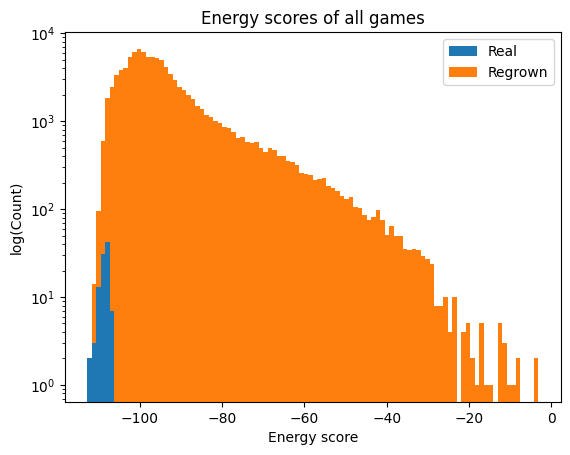

In [29]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

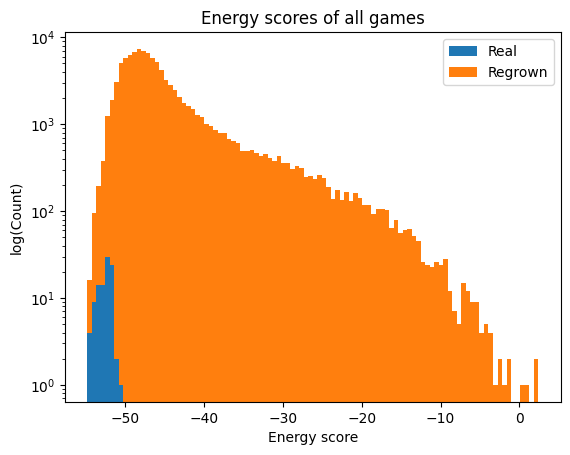

In [30]:
utils.plot_energy_histogram(l1_1e2_model, full_tensor)